### Student:Rickard Sörlin

- I did not request a formal review for this lab, so there was no feedback to incoperate.

- AI tools like GitHub Copilot and ChatGPT were used as support to understand the existing code provided in notebooks like functions,arguments and methods
and to get a deeper explaination of concepts. They were also used whern i got stuck, needed to complete missing parts, or ecountered unexpected errors.

- Through the lab, I made sure I understood the suggestions i recieved before applying them. Using AI support helped improve my learning, since it encouraged me to ask follow-up questions such why a specific argument or methods was used and what alternatives could work. I then adapted the suggestions to fit my own solution.




# Lab 2: GPT from scratch

In this lab, you will dive into the inner workings of the GPT architecture. You will walk through a complete implementation of the architecture in PyTorch, instantiate this implementation with pre-trained weights, and put the resulting model to the test by generating text. At the end of this lab, you will understand the building blocks of the GPT architecture and how they are connected.

*Tasks you can choose for the oral exam are marked with the graduation cap 🎓 emoji.*

In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn

## Part 1: GPT architecture

GPT-2 was first described by [Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). To faithfully implement the model, one needs to also read the earlier paper by [Radford et al. (2018)](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). Another important source of information is the official implementation, which is available on GitHub ([link](https://github.com/openai/gpt-2)).

The GPT architecture is made up of a stack of Transformer blocks. Each block has two main parts: one handles multi-head self-attention, and the other is a feed-forward network. Before these parts do their work, their input undergoes layer normalisation, and residual connections are added to help the model learn more effectively. The input to the architecture is a sequence of token IDs. These are turned into embeddings and augmented with information about the absolute position of each token in the sequence. The output layer converts the internal representations into logit scores for every token in the vocabulary.

### Model configuration

[Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) present four increasingly larger GPT models based on the same architecture. Here, we will implement the smallest of these, characterised by the following hyperparameters:

In [2]:
@dataclass
class Config:
    n_vocab: int = 50257
    n_ctx: int = 1024
    n_embd: int = 768
    n_head: int = 12
    n_layer: int = 12

#### 🎈 Task 2.01: Model configuration

Explain the purpose of these hyperparameters. In particular, where does the number 50,257 come from?

# Answer:
The purpose of hyperparameters is that they hold information about the models defined architecture. 
Like n_head=12 that defines the number of attention heads, the n_vocab set to 50257 tells the model that it has a vocabulary size of 50257 unique tokens to represents the language to be generated in.  

### GELU activation function

We start by implementing the feed-forward network. This is a standard two-layer network with a Gaussian Error Linear Unit (GELU) activation function ([Hendrycks and Gimpel, 2016](https://doi.org/10.48550/arXiv.1606.08415)).

The GELU is a smooth version of the rectified linear unit (ReLU) that weights inputs by their value under the cumulative distribution function of the standard Gaussian. This function is commonly denoted by $\Phi$. For example, $\text{GELU}(0{.}5) = 0{.}5 \cdot \Phi(0{.}5) \approx 0{.}5 \cdot 0{.}6915 = 0{.}3457$ because approximately 69.15% of normally distributed data lies to the left of $0{.}5$.

When GPT-2 was released, computing the GELU exactly was expensive, and the official implementation therefore used an approximation originally presented by [Choudhury (2014)](https://dx.doi.org/10.13189/ms.2014.020307). We follow suit here, as we want to create a replica of the original model. However, it is worth mentioning that PyTorch now offers an exact implementation of the GELU so fast that using an approximation is unnecessary.

In [3]:
def gelu(x):
    return 0.5 * x * (1 + torch.tanh((2 / torch.pi) ** 0.5 * (x + 0.044715 * x**3)))

#### 🎓 Task 2.02: Mathematical properties of the GELU

Find the minimal output value of the GELU and the input value for which it yields that output. Use a service such as [WolframAlpha](https://www.wolframalpha.com/) for the necessary derivations. What are the main differences between the GELU and the ReLU?

https://www.desmos.com/calculator/fwsdnqqcta
(-0.752461,-0.170041)

The minimal ouput of GELU is where input value X = -0.752461 will result in a output of y = -0.170041.
See attached image in lab2 folder.

ReLu transforms all negative input to 0 and has a linear transformation of output when x > 0, while GELU applies a smooth, non-linear transformation to all input values and GELU allows small negative values.


![GELU and ReLu.png](<attachment:GELU and ReLu.png>)

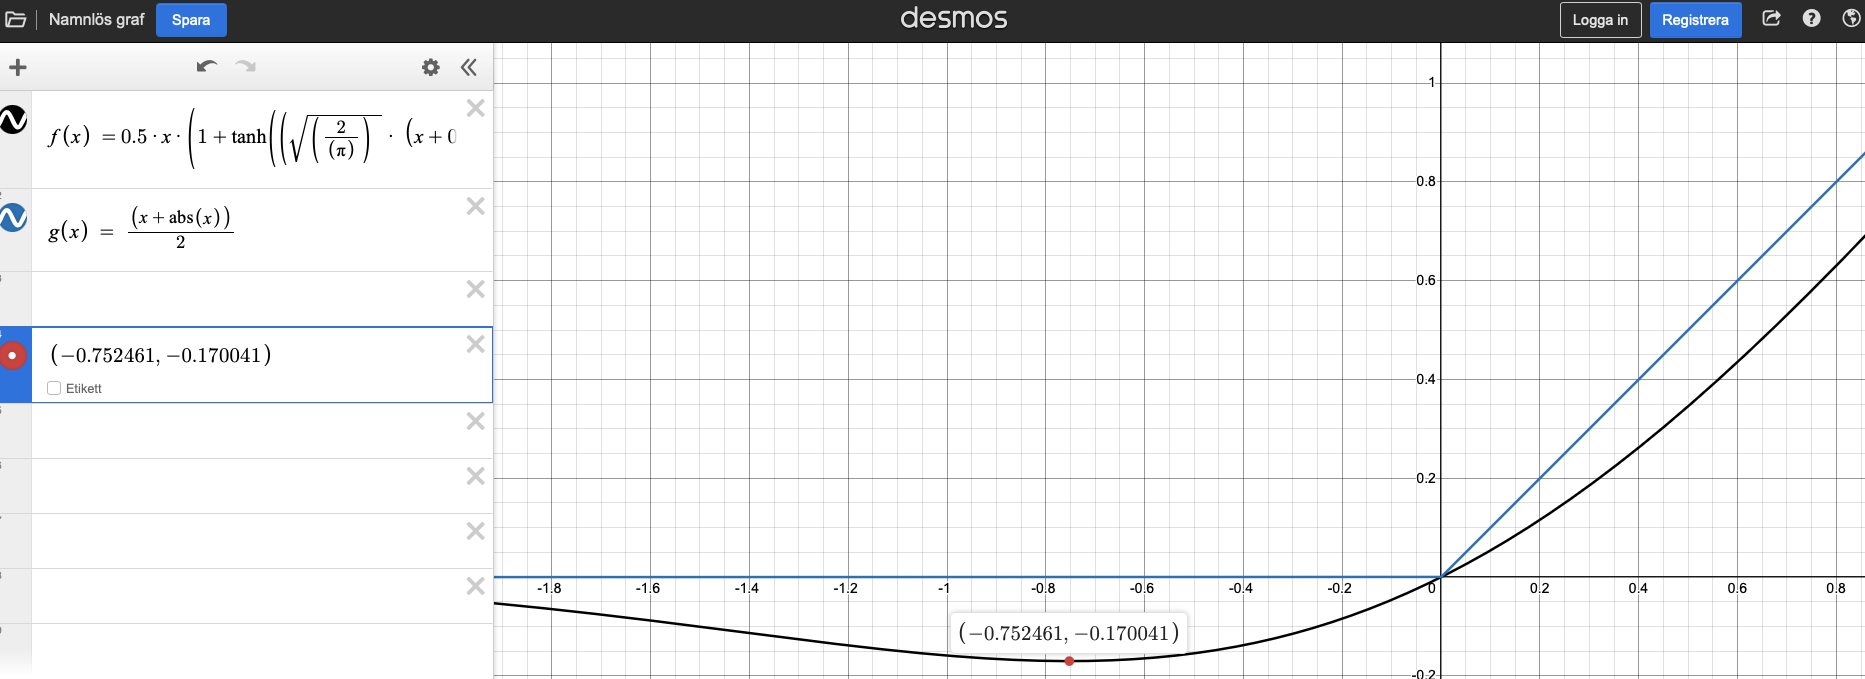

### Feed-forward network

Next, here is the code for the feed-forward network. Note that we follow the official codebase and use the name **multi-layer perceptron (MLP)** rather than “feed-forward network”.

In [4]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)

    def forward(self, x):
        batch_size, seq_len, n_embd = x.shape # Shape : [2 , 3 , 768]
        x = self.c_fc(x)   # X: [batch_size , seq_len , n_embd * 4]  
        x = gelu(x)      # X: [batch_size , seq_len , n_embd * 4] Doesnt change shape
        x = self.c_proj(x) 
      # X: [batch_size , seq_len , n_embd]
        return x

#### 🎓 Task 2.03: Shape annotations

One of the most common errors in deep learning is a mismatch in tensor dimensions. To avoid this, it is good practice to annotate PyTorch code with shapes. For example, suppose you are given the following code:

In [5]:
f = nn.Linear(5, 7)
x = torch.rand(2, 3, 5)
y = f(x)

The annotation of this code with shapes would look as follows:

In [6]:
f = nn.Linear(5, 7)
# not a tensor variable; needs no annotation

x = torch.rand(2, 3, 5)
# shape of x: [2, 3, 5]

y = f(x)
# shape of y: [2, 3, 7]

Annotate the shapes in the `forward()` method of the feed-forward network. Instead of using actual numbers, refer to dimension sizes by symbolic names such as `n_embd`, `batch_size` (number of samples in a batch of input data) and `seq_len` (length of an input sequence). You can introduce additional names and other notation you find useful. Make your annotations as detailed as you need them to explain how the shapes change from one line to the next.

In [7]:
# testing MLP class implementation with shape [2, 3, 768]
x = torch.rand(2, 3, 768)
mlp = MLP(Config())
mlp.forward(x)

tensor([[[-0.0464,  0.1500, -0.0823,  ..., -0.0459, -0.0142, -0.1708],
         [-0.0536,  0.0815, -0.0710,  ..., -0.0955, -0.0364, -0.0754],
         [-0.0188,  0.0378, -0.0378,  ..., -0.0830, -0.0496, -0.1911]],

        [[ 0.0047,  0.1717, -0.1027,  ..., -0.0566, -0.0402, -0.1628],
         [-0.0385,  0.0809, -0.0166,  ..., -0.1444,  0.0395, -0.0990],
         [-0.0275,  0.0200, -0.1414,  ..., -0.0339, -0.0624, -0.1472]]],
       grad_fn=<ViewBackward0>)

### Causal mask

Our next goal is to implement the core of the GPT architecture: the multi-head attention mechanism.

Recall that the attention mechanism in the Transformer decoder must be restricted to attending only to previously generated tokens. This type of attention is also called **causal attention**. In practice, we implement it through a masking technique that sets the post-softmax attention weights of future tokens to zero. The following utility function implements such a mask:

In [8]:
def make_causal_mask(n):
    return torch.triu(torch.full((n, n), float("-inf")), diagonal=1)

#### 🎈 Task 2.04: Causal mask

Have a close look at the following code and run it to see the result. What are the shapes of `x` and `mask`? Given that the shapes are different, why does the addition operation in the last line not raise an error? What is the shape of the result? How does the addition operation implement masking? (Recall that the attention scores are normalised using the softmax function.)

In [9]:
x = torch.rand(1, 2, 3, 3)
# x: [1, 2, 3, 3]
mask = make_causal_mask(5)
# mask: [5, 5]
casualmask = x + mask[:3, :3] 
# broadcasting the mask to the shape of x , elementwise addition and setting upper triangle to -inf
# making sure that each token can only attend to previous tokens and itself
casualmask.shape
# x: [1, 2, 3, 3]



torch.Size([1, 2, 3, 3])

### Attention mechanism

Here is the code for the multi-head attention mechanism:

In [10]:
class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.register_buffer("mask", make_causal_mask(config.n_ctx), persistent=False)

    def forward(self, x):
        batch_size, seq_len, n_embd = x.shape

        # [batch_size, seq_len, n_embd] = during my test [2, 3, 768]
        head_embd = n_embd // self.n_head
        # 768/12 = 64 = head_embd
        
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        # q, k, v = [batch_size, seq_len, n_embd] = during my test [2, 3, 768]
        
        q = q.view(batch_size, seq_len, self.n_head, head_embd)
        # q = [batch_size, seq_len, n_head, head_embd] = during my test [2, 3, 12, 64]
        k = k.view(batch_size, seq_len, self.n_head, head_embd)
        # k = [batch_size, seq_len, n_head, head_embd] = during my test [2, 3, 12, 64]
        v = v.view(batch_size, seq_len, self.n_head, head_embd)
        # v = [batch_size, seq_len, n_head, head_embd] = during my test [2, 3, 12, 64]
        q = q.transpose(-2, -3)
        # q = [batch_size, n_head, seq_len, head_embd] = during my test [2, 12, 3, 64]
        k = k.transpose(-2, -3)
        # k = [batch_size, n_head, seq_len, head_embd] = during my test [2, 12, 3, 64]
        v = v.transpose(-2, -3)
        # v = [batch_size, n_head, seq_len, head_embd] = during my test [2, 12, 3, 64]
        x = q @ k.transpose(-1, -2)
        # x = [batch_size, n_head, seq_len, seq_len] = during my test [2, 12, 3, 3]
       
        x = x / head_embd**0.5
        # x = [batch_size, n_head, seq_len, seq_len] = during my test [2, 12, 3, 3]

        x = x + self.mask[:seq_len, :seq_len]# broadcasting the mask to the shape of x , elementwise addition and setting upper triangle to -inf
        # x = [batch_size, n_head, seq_len, seq_len] = during my test [2, 12, 3, 3]
   
        x = torch.softmax(x, dim=-1)
        # x = [batch_size, n_head, seq_len, seq_len] = during my test [2, 12, 3, 3]
     
        x = x @ v
        # x = [batch_size, n_head, seq_len, head_embd] = during my test [2, 12, 3, 64]
        x = x.transpose(-2, -3).contiguous()
        # x = [batch_size, seq_len, n_head, head_embd] = during my test [2, 3, 12, 64]
        x = x.view(batch_size, seq_len, n_embd)
        #  x = [batch_size, seq_len, n_embd] = during my test [2, 3, 768]
        x = self.c_proj(x)
        # x = [batch_size, seq_len, n_embd] = during my test [2, 3, 768]
        return x

#### 🎓 Task 2.05: Multi-head attention

Trace the input `x` through the `forward()` method line by line and annotate the shapes of all tensor variables. Identify all lines that rely on broadcasting.

In [11]:
timeforattention = Attention(Config())
x = torch.rand(2, 3, 768)
timeforattention.forward(x)

tensor([[[-0.1842, -0.2779, -0.0941,  ...,  0.2794,  0.1017,  0.3695],
         [-0.1578, -0.2363, -0.1552,  ...,  0.2089,  0.1561,  0.3032],
         [-0.1289, -0.1822, -0.1509,  ...,  0.2115,  0.1704,  0.2911]],

        [[-0.1951, -0.3188,  0.0033,  ...,  0.0555,  0.3522,  0.2086],
         [-0.2330, -0.2130, -0.0064,  ...,  0.1065,  0.2253,  0.2870],
         [-0.1801, -0.2464, -0.0330,  ...,  0.0727,  0.1601,  0.2363]]],
       grad_fn=<ViewBackward0>)

### Layer normalisation

As mentioned above, the inputs to both the feed-forward network and the multi-head attention mechanism undergo **layer normalisation**. This normalises the inputs to have zero mean and unit variance across the activations. [Ba et al. (2016)](https://doi.org/10.48550/arXiv.1607.06450) introduce two trainable parameters (called $\gamma$ and $\beta$ in the paper) that allow the network to learn an appropriate scale and shift for the normalised values.

We implement layer normalisation as follows:

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.g = nn.Parameter(torch.ones(config.n_embd))
        self.b = nn.Parameter(torch.zeros(config.n_embd))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # When computing the mean over the last dimension, we keep the dimension for broadcasting purposes
        variance = x.var(unbiased=False, dim=-1, keepdim=True)
        return self.g * (x - mean) / torch.sqrt(variance + 1e-05) + self.b

#### 🎈 Task 2.06: Layer normalisation

What is the relevance of the `keepdim=True` keyword argument in the `mean()` and `var()` functions? What would happen if we omitted it?

### Setting argument keepdim=True will ensure the output tensor from mean() and var() keeps the same number of dimensions as the input tensor. It will make mathimathical operation possible like the subtraction done bellow and allow broadcasting, else a runtime error will arise.



What is the relevance of the constant 1e-05? What could happen if we omitted it?

### Its there to prevent division by zero if variance is zero else the operation might cause a runtime error.


### Decoder block

We now combine the feed-forward network, the multi-head attention mechanism and the layer normalisation into a decoder block.

In [13]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config)
        self.attn = Attention(config)
        self.ln_2 = LayerNorm(config)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

#### 🎓 Task 2.07: Pre-norm and post-norm architectures

The original Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)) is a “post-norm architecture”, where the normalisation is applied **after** each residual block. In contrast, GPT-2 is a “pre-norm architecture”, where the normalisation is applied **before**. Find the passage in Section&nbsp;2.3 of [Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) that reports on this modification.


### Layer normalization (Ba et al., 2016) was moved to the input of each sub-block, similar to a pre-activation residual network (He et al., 2016) and an additional layer normalization was added after the final self-attention block.


[Xiong et al. (2020)](https://arxiv.org/pdf/2002.04745) compare pre-norm and post-norm architectures empirically. Read the abstract of their paper and summarise their main findings. According to these findings, what are the benefits of the pre-norm architecture?

### Their main findings in the paper shows that moving LayerNorm inside the residual block makes gradients well-behaved at initialization, which made it possible to drop the learning-rate warm up.The change made the gradients more stable and trained faster with also less hyperparameter tuning. And still had comparable performence to post-norm.  

### Model

We now have almost all components in place to complete the implementation of the GPT-2 model. The only thing  missing are the position embeddings. These simply associate an embedding vector with every position in the context window. To set them up, we first define another utility function:

In [14]:
def make_positions(n):
    return torch.arange(n, dtype=torch.long)

We then code the complete model as follows:

In [15]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.n_vocab, config.n_embd)
        self.wpe = nn.Embedding(config.n_ctx, config.n_embd)
        self.h = nn.Sequential(*(Block(config) for _ in range(config.n_layer)))
        self.ln_f = LayerNorm(config)
        self.lm_head = nn.Linear(config.n_embd, config.n_vocab, bias=False)
        self.lm_head.weight = self.wte.weight  # token embedding and final linear layer weight sharing
        self.register_buffer("pos", make_positions(config.n_ctx), persistent=False)

    def forward(self, x):
        batch_size, seq_len = x.shape
        wte = self.wte(x)
        wpe = self.wpe(self.pos[:seq_len])
        x = wte + wpe
        x = self.h(x)
        x = self.ln_f(x)
        x = self.lm_head(x)
        return x

#### 🎈 Task 2.08: Buffers

Our implementation registers the vector of positions as a buffer. (Earlier, we also registered the causal mask as a buffer.) Consult the PyTorch documentation to determine the benefits of registering a tensor as a buffer, in contrast to computing it in the `forward()` method.

### The benefits of regestering a tensor as a buffer it that it will not be considered as a model parameter, but still persistent by default in the state_dict. If computing it in forward() would mean more computation for those tensors hence more memory usage also.

#### 🎓 Task 2.09: Number of trainable parameters

The model we have implemented is the smallest one presented by [Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). But how many trainable parameters exactly does it have? Interestingly, the number originally reported by the authors is wrong. (What number did they report?)

### They Reported 117M

Your task is to write code to compute the number of parameters yourself. This should only take 1–3 lines of code. What number do you get when you apply this code to a fresh model instance?

### 163M (163037184)

[Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) followed the original Transformers paper ([Vaswani et al., 2017](https://doi.org/10.48550/arXiv.1706.03762)) and shared the trainable weights between the token embedding and the final linear layer. Implement this weight sharing strategy. (Hint: This only requires one line of code.) Then, re-compute the number of trainable parameters for the modified model. 

What number do you get now? 
### 124439808

How large is the reduction caused by the weight sharing?

### 163037184 - 124439808 = 38597376 (38.5M)


In [16]:
TheModel = Model(Config())
count = 0
for parameter in TheModel.parameters():
    count += parameter.numel()

print(count)




124439808


## Part 2: Load pre-trained weights

Now that you have a complete implementation of the GPT-2 model in place, you can instantiate it by loading the pre-trained weights released by OpenAI. These weights were originally provided in the TensorFlow format. For this lab, we have re-packaged them as a single file in NumPy’s `.npz` archive format ([link](http://www.ida.liu.se/~TDDE09/lfs/gpt-2-pretrained.npz)). Note that the file weighs in at 463&nbsp;MB. We can load it as follows:

In [17]:
import numpy as np

pretrained = np.load("gpt-2-pretrained.npz")

The contents of the archive are files in the `.npy` format, each containing a single NumPy array. When you print the file names, you will see that you can map them to the attributes of the network modules you have seen above. For example, the file `h0.attn.c_attn.b` corresponds to the biases (`b`) of the `c_attn` linear layer in the attention mechanism (`attn`) of the first transformer block (`h0`). We can verify that the array has the correct shape:

In [18]:
pretrained["h0.attn.c_attn.b"].shape


(2304,)

In [19]:
for file in pretrained.files:
    print(file)

h0.attn.c_attn.b
h0.attn.c_attn.w
h0.attn.c_proj.b
h0.attn.c_proj.w
h0.ln_1.b
h0.ln_1.g
h0.ln_2.b
h0.ln_2.g
h0.mlp.c_fc.b
h0.mlp.c_fc.w
h0.mlp.c_proj.b
h0.mlp.c_proj.w
h1.attn.c_attn.b
h1.attn.c_attn.w
h1.attn.c_proj.b
h1.attn.c_proj.w
h1.ln_1.b
h1.ln_1.g
h1.ln_2.b
h1.ln_2.g
h1.mlp.c_fc.b
h1.mlp.c_fc.w
h1.mlp.c_proj.b
h1.mlp.c_proj.w
h10.attn.c_attn.b
h10.attn.c_attn.w
h10.attn.c_proj.b
h10.attn.c_proj.w
h10.ln_1.b
h10.ln_1.g
h10.ln_2.b
h10.ln_2.g
h10.mlp.c_fc.b
h10.mlp.c_fc.w
h10.mlp.c_proj.b
h10.mlp.c_proj.w
h11.attn.c_attn.b
h11.attn.c_attn.w
h11.attn.c_proj.b
h11.attn.c_proj.w
h11.ln_1.b
h11.ln_1.g
h11.ln_2.b
h11.ln_2.g
h11.mlp.c_fc.b
h11.mlp.c_fc.w
h11.mlp.c_proj.b
h11.mlp.c_proj.w
h2.attn.c_attn.b
h2.attn.c_attn.w
h2.attn.c_proj.b
h2.attn.c_proj.w
h2.ln_1.b
h2.ln_1.g
h2.ln_2.b
h2.ln_2.g
h2.mlp.c_fc.b
h2.mlp.c_fc.w
h2.mlp.c_proj.b
h2.mlp.c_proj.w
h3.attn.c_attn.b
h3.attn.c_attn.w
h3.attn.c_proj.b
h3.attn.c_proj.w
h3.ln_1.b
h3.ln_1.g
h3.ln_2.b
h3.ln_2.g
h3.mlp.c_fc.b
h3.mlp.c_fc.w


#### 🎓 Task 2.10: Load pre-trained weights

Create a model from the pre-trained weights. To do this, you need to instantiate a fresh model and write the contents of each array from the `npz` archive with the pre-trained weights into the corresponding tensor. To make this a bit easier, here is a utility function that re-initialises a PyTorch tensor `target` with data from a NumPy array `source`:

In [20]:
def reinit(target: torch.Tensor, source: np.ndarray):
    assert source.shape == target.shape
    with torch.no_grad():
        target.copy_(torch.tensor(source, dtype=torch.float32))

You can start from this skeleton code:

In [21]:
def from_pretrained() -> Model:
    model = Model(Config())
    pretrained = np.load("gpt-2-pretrained.npz")
    # TODO: Implement the reinitialisation of the model's parameters
    
    
    return model

One technical detail to note is that PyTorch stores the weights of linear layers in a transposed form. For example, a linear layer created as `nn.Linear(2, 3)` has a weight matrix of shape [3, 2].

## Part 3: Put the model to use

In the third and final part of this lab, you will use the pre-trained model to generate text and evaluate it on a standard benchmark.

### Sampling-based text generation

The easiest way to generate text with a language model is by using a **greedy approach**. This method works by creating text one token at a time. At each step, the model takes the previously generated text (called the **context**) as input and adds the token with the highest output logit as a new token. The code in the next cell defines a function `generate()` that forms the core of a greedy generator:

In [22]:
def generate(model, context, context_size=1024, n_tokens=20):
    for _ in range(n_tokens):
        context = context[:, -context_size:]
        with torch.no_grad():
            logits = model(context)[:, -1, :]
        next_idx = torch.argmax(logits, dim=-1, keepdim=True)
        context = torch.cat([context, next_idx], dim=-1)
    return context

To use this function with an actual text input, you need a tokeniser to first encode the text into a vector of token IDs, and later decode the generated `context` into new text. The reference implementation of the GPT-2 tokeniser is in the library `tiktoken`. The code in the next cell sets up the tokeniser, loads the pretrained model from Task&nbsp;2.10, and then defines a helper function that handles the encoding and decoding.

In [83]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
model = from_pretrained()


def generate_helper(text, context_size=1024, n_tokens=20):
    context = torch.tensor([tokenizer.encode(text)], dtype=torch.long)
    context = generate(model, context, context_size=context_size, n_tokens=n_tokens)
    return tokenizer.decode(context[0].tolist())

You can use this helper function to generate text as follows:

In [56]:
generate_helper("Linköping University is")

'Linköping University is is is is is is is is is is is is is is is is is is is is is'

**Tip:** If you did not manage to complete Task&nbsp;2.10, you can still work on this task by using a pretrained GPT-2 model from [Hugging Face](https://huggingface.co/openai-community/gpt2). The next code cell shows how you would instantiate this model. Note that you may have to first install the `transformers` library.

In [84]:
from transformers import GPT2LMHeadModel


context = torch.tensor([tokenizer.encode("My name is Rickard")], dtype=torch.long)

model = GPT2LMHeadModel.from_pretrained("gpt2")
logits = model(context).logits[:, -1, :]




In [100]:
generate_helper("Linköping University is")

'Linköping University is the first to offer a free, online course in English language communication, with a focus on teaching students'

In [102]:
generate_helper("Is Linköping University located in Kina?") 

'Is Linköping University located in Kina?\n\n\nYes, Linköping University is located in the city of Kina, Sweden. Link'

#### 🎓 Task 2.11: Sampling-based text generation

 The greedy approach to text generation is not very interesting for practical applications because it always chooses the most likely token, leading to predictable and less creative results. Your task is to modify the code for the `generate()` function to use a **sampling-based approach** instead. In this approach, the next token is chosen randomly based on the probabilities assigned by the model (softmax-normalised logits), treating them as a categorical distribution over the token vocabulary. Additionally, your code should include two common techniques to improve sampling:
 
 * **temperature scaling**, which lets the user control the randomness of the sampling
 * **top-$k$ sampling**, which limits the sampling to the top-$k$ most likely tokens, ignoring less probable ones

In [ ]:
def generate1(model, context, context_size=1024, n_tokens=20):
    for _ in range(n_tokens):
        context = context[:, -context_size:]
        with torch.no_grad():
            logits = model(context)[:, -1, :]
        next_idx = torch.argmax(logits, dim=-1, keepdim=True)
        context = torch.cat([context, next_idx], dim=-1)
    return context

In [99]:
def generate(model, context, context_size=1024, n_tokens=20, temperature=1.0, top_k=3):
    for _ in range(n_tokens):
        context = context[:, -context_size:]
        with torch.no_grad():
            out = model(context)
            logits = out.logits if hasattr(out, "logits") else out
            logits = logits[:, -1, :]  # [batch, vocab]

            # Greedy fallback if temperature is 0 or less
            if temperature is not None and temperature <= 0:
                next_idx = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                logits = logits / temperature

                if top_k is not None and top_k > 0 and top_k < logits.size(-1):
                    values, indices = torch.topk(logits, top_k)
                    mask = torch.full_like(logits, float('-inf'))
                    mask.scatter_(1, indices, values)
                    logits = mask

                probs = torch.softmax(logits, dim=-1)
                next_idx = torch.multinomial(probs, num_samples=1)
        context = torch.cat([context, next_idx], dim=-1)
    return context

### Evaluating the pretrained model

If you have experimented with your pretrained GPT-2 model, you will have noticed that its ability to generate useful text is somewhat limited. By today’s standards, GPT-2 is a small model with modest capabilities. However, it can still be helpful for certain tasks, such as text autocompletion, generating filler text, or answering simple questions. To rigourosly evaluate language models, researchers often use standard benchmark datasets. Creating these benchmarks is a discipline of its own, and they tend to become increasingly challenging as models continue to improve.

In the final task of this lab, you will evaluate GPT-2’s performance on a small subset of the [HellaSwag dataset](https://rowanzellers.com/hellaswag/), which was published in the same year as GPT-2 itself (2019). HellaSwag is designed to test a model’s ability to perform commonsense reasoning in challenging contexts. Unlike simpler benchmarks, HellaSwag presents scenarios where the correct text completion depends on semantic relationships between events and on world knowledge. This makes it a good choice for assessing the ability of language models to go beyond surface-level patterns and produce meaningful, context-aware predictions.

#### 🎓 Task 2.12: Evaluating the pretrained model

Read the [HellaSwag website](https://rowanzellers.com/hellaswag/) to get some background on the benchmark. 
How does a sample from the dataset look like? 
### Each sample has a ctx, four candidate endings, and a label giving the index of the correct ending.
What is an expected prediction?
### To choose the best index of best ending string 
How does the benchmark allow us to score models? 
### The amount of correct of the set in percent
What is the random baseline?
### Four choices  
What is the human performance reported on the task?
### 95.6 overall accuracy

The next cell contains code for evaluating your pretrained model on a small sample from HellaSwag. You will also need a tokenizer. The HellaSwag subset is in the file `hellaswag-mini.jsonl`. Inspect that file to understand the format. 

Next, read the code and explain how it works. Specifically, how does the code compute the score of individual endings? 

In the call to `cross_entropy()`, why are the tensors sliced in this specific way?

Finally, what overall score does the pretrained GPT-2 model get on this benchmark? 
### A overall score of 30.47 % 

How does that score compare to the random baseline and the human performance?
### Its sligthly above the randome baseline that got 25% but far from human performence of 95.6%

In [31]:
import json

with open("hellaswag-mini.jsonl") as f:
    n_correct = 0
    n_total = 0
    for line in f:
        sample = json.loads(line)
        prefix = tokenizer.encode(sample["ctx"])
        ending_scores = []
        for i, ending in enumerate(sample["endings"]):
            suffix = tokenizer.encode(" " + ending)
            context = torch.tensor([prefix + suffix], dtype=torch.long)
            with torch.no_grad():
                logits = model(context).logits
                ending_score = torch.nn.functional.cross_entropy(
                    # Evaluate how well the model predicts each ending.
                    # For each predicted (Yhat) logit logits[0, -len(suffix) - 1 : -1] in the ending, 
                    # calculate the log likelihood (cross-entropy) against actual ground truth token ids context[0, -len(suffix) :] (Y).
                    logits[0, -len(suffix) - 1 : -1], context[0, -len(suffix) :]
                    # By this we get a score for for each ending, the lower the better.
                )
                # Store the ending score along with the index of the ending
            ending_scores.append((ending_score, i))
            # Take the ending with the lowest score (highest likelihood) as the model's prediction
        predicted = min(ending_scores)[1]
        n_correct += int(predicted == sample["label"])
        n_total += 1
    print(f"Accuracy: {n_correct / n_total:.2%}")

Accuracy: 30.47%


**🥳 Congratulations on finishing lab&nbsp;2!**